In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import seaborn as sns

In [136]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                     encoding = 'UTF-8')
data = data.drop(['add', 'Unnamed: 0'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   ca      3957 non-null   float64
 2   avg_ta  3957 non-null   float64
 3   sum_rn  3957 non-null   float64
 4   new_wd  3957 non-null   float64
 5   new_ws  3957 non-null   float64
dtypes: float64(5), object(1)
memory usage: 185.6+ KB


In [119]:
print(data.loc[data.date <= '2021-12-31',:].shape)

#train test split index 지정
TRAIN_SPLIT = 3653

(3653, 6)


#**Univariate**

In [120]:
#data 에서 온도만 추출 후 time series로 변경
uni_data = data['sum_rn']
uni_data.index = data['date']
uni_data.head()

date
2012-01-01    0.0
2012-01-02    0.0
2012-01-03    0.0
2012-01-04    0.0
2012-01-05    0.0
Name: sum_rn, dtype: float64

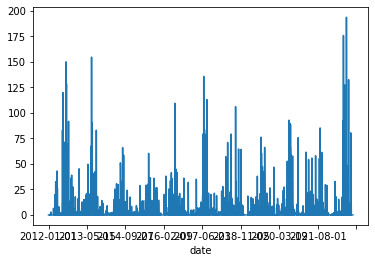

In [121]:
#time series plot
uni_data.plot()

In [122]:
#value만 할당
uni_data = uni_data.values

#scaling : 표준화
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [128]:
#time window 생성
'''
history_size = 몇 개의 과거 데이터 학습
target_size = 예측 label (얼마나 멀리있는 예측 배우나)
'''
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i - history_size, i)

    #위에서 (history_size,)였던 데이터 형식을 (history_size,1)로 변경
    data.append(np.reshape(dataset[indices], (history_size,1)))
    labels.append(dataset[i+target_size])

  return np.array(data), np.array(labels) #array형식으로 변경

In [134]:
#20일 관측치 기반으로 예측
uni_past_his = 20
uni_future_target = 0

X_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           uni_past_his, uni_future_target)
X_test_uni, y_test_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                           uni_past_his, uni_future_target)


In [135]:
print('single window of past hist')
print(X_train_uni[0])
print('\n target to predict')
print(y_train_uni[0])

single window of past hist
[[-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.27811009]
 [-0.2555451 ]
 [-0.23749311]]

 target to predict
-0.27209275744666594


#**Multivariate**

             ca  avg_ta  sum_rn    new_wd  new_ws
date                                             
2012-01-01  5.1    -2.7     0.0 -606.6210 -9.6589
2012-01-02  2.9    -4.6     0.0 -501.4768 -5.1131
2012-01-03  7.5    -4.3     0.0 -607.3124 -7.7681
2012-01-04  1.1    -6.8     0.0 -613.9938 -7.9552
2012-01-05  0.0    -5.2     0.0 -581.0362 -5.4605


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f511a275250>,
      dtype=object)

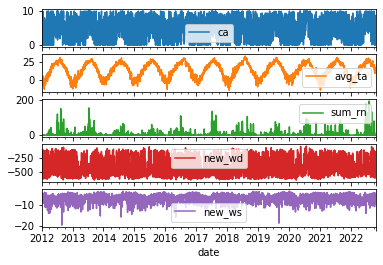

In [137]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
print(data.head())
data.plot(subplots = True)

In [141]:
#train_test split
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:TRAIN_SPLIT]
test_df = data[TRAIN_SPLIT:]

num_features = data.shape[1]

In [142]:
#data scaling
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

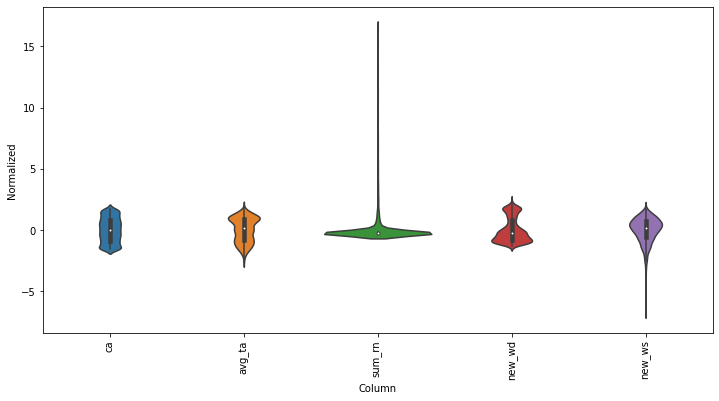

In [143]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data.keys(), rotation=90)

In [144]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width = 50, label_width = 10, shift = 24)

In [116]:
data_input=data[['ca','avg_ta', 'new_wd', 'new_ws', 'sum_rn']]

In [117]:
#Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_input) ; data_scaled

array([[0.51      , 0.24217119, 0.04919675, 0.60641615, 0.        ],
       [0.29      , 0.20250522, 0.23011978, 0.88162395, 0.        ],
       [0.75      , 0.20876827, 0.04800704, 0.72088729, 0.        ],
       ...,
       [0.11      , 0.59290188, 0.80892889, 0.90911568, 0.        ],
       [0.11      , 0.59498956, 0.77470562, 0.90616732, 0.        ],
       [0.4       , 0.60751566, 0.46296775, 0.89057193, 0.        ]])

In [ ]:
X_train = data_scaled
y_train = scaler.fit_transform(data['sum_rn'])

In [60]:
features = data_scaled
target = data_scaled[:,0]

In [61]:
TimeseriesGenerator(features,target,length=2,
                    sampling_rate=1,batch_size=1)[0]

(array([[[0.51      , 0.24217119, 0.04919675, 0.60641615, 0.        ],
         [0.29      , 0.20250522, 0.23011978, 0.88162395, 0.        ]]]),
 array([0.75]))

In [62]:
features = pd.DataFrame(features)

In [94]:
X_train = features.iloc[:3653,:4]
y_train = features.iloc[:3653,4]
X_test = features.iloc[3653:,:4]
y_test = features.iloc[3653:,4]

In [75]:
print(X_train.shape)
print(y_train.shape)

(3653, 4)
(3653,)


In [110]:
n_past = 50
n_future = 3
n_features = 4

In [111]:
X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))

AttributeError: ignored

In [100]:
length = 50
batch_size = 1
num_features= 4
train_generator = TimeseriesGenerator(X_train, y_train, length=length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=length, sampling_rate=1, batch_size=batch_size)

In [101]:
train_generator[0]

(array([[[0.51      , 0.24217119, 0.04919675, 0.60641615],
         [0.29      , 0.20250522, 0.23011978, 0.88162395],
         [0.75      , 0.20876827, 0.04800704, 0.72088729],
         [0.11      , 0.1565762 , 0.03651027, 0.70956005],
         [0.        , 0.18997912, 0.09322085, 0.86059197],
         [0.31      , 0.24217119, 0.07235376, 0.83928755],
         [0.        , 0.22338205, 0.25522361, 0.95756068],
         [0.68      , 0.2526096 , 0.12607375, 0.88182979],
         [0.64      , 0.29227557, 0.15016305, 0.87576357],
         [0.19      , 0.25052192, 0.08079902, 0.80330191],
         [0.        , 0.18997912, 0.04295365, 0.69421893],
         [0.45      , 0.21920668, 0.29182215, 0.83914225],
         [0.33      , 0.27974948, 0.08033478, 0.73334665],
         [0.25      , 0.27348643, 0.15120132, 0.80006296],
         [0.46      , 0.2526096 , 0.06477884, 0.85477397],
         [0.14      , 0.31106472, 0.70974662, 0.93046247],
         [0.43      , 0.35281837, 0.08454226, 0.89092307

In [106]:
import tensorflow as tf
from keras import optimizers
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(LSTM(128,input_shape=(length,num_features),return_sequences=True))

model.add(Dense(1))

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam,
              metrics=[tf.metrics.MeanAbsoluteError()])


In [107]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 50, 128)           68096     
                                                                 
 dense_5 (Dense)             (None, 50, 1)             129       
                                                                 
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [108]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)
history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    shuffle=False,
    callbacks = [early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


3601/3603 [============================>.] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0272

KeyError: ignored

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()